# Consigna NX - Challenge.

Cada una de las filas del archivo (indexada por SK_ID_CURR) corresponde a una persona distinta que nos pidió un préstamo, y la columna "TARGET" dice qué ocurrió con ese pedido en particular (es decir, tiene un 1 si su pago se atrasó , es decir, que entraron en default, y 0 si no lo hizo). La idea es que puedas hacer un proceso que permita predecir los clientes futuros que van a entrar en default sobre el préstamo.
El archivo "HomeCredit_columns_description - HomeCredit_columns_description.parquet" tiene la información disponible sobre cada una de las columnas de los otros archivos adjuntos. 

Para poder orientarte nuestra evaluación, vamos a hacer foco en el EDA y en el modelo predictivo, sin entrar en profundidad si la métrica esta tuneada o no.

# EDA para credit_card_balance.parquet

In [1]:
%reset -f

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import seaborn as sns

In [3]:
df = pd.read_parquet('/Users/santiagogimenez/Desktop/NX - Challenge/drive-download-20221102T125102Z-001/Copia de credit_card_balance.parquet', engine='pyarrow')
df.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [4]:
#Tamaño del dataset
df.shape

(3840312, 23)

Tengo tres tipos de datos en nuestro dataset. Objetos, flotantes y enteros. Tengo que discernir si es necesario convertir alguna de las columnas a otro tipo de datos.

In [5]:
#conteo de cada tipo de dato
pd.value_counts(df.dtypes)

float64    15
int64       7
object      1
dtype: int64

## Estructura de datos

### Estructura de datos no-numericos 

In [6]:
# La variable categorica se puede pasar a un OHE

df.select_dtypes(exclude='number').head()

,NAME_CONTRACT_STATUS
0,Active
1,Active
2,Active
3,Active
4,Active


In [7]:
df.describe(exclude='number').T

,count,unique,top,freq
NAME_CONTRACT_STATUS,3840312,7,Active,3698436


### Estructura de datos numericos 

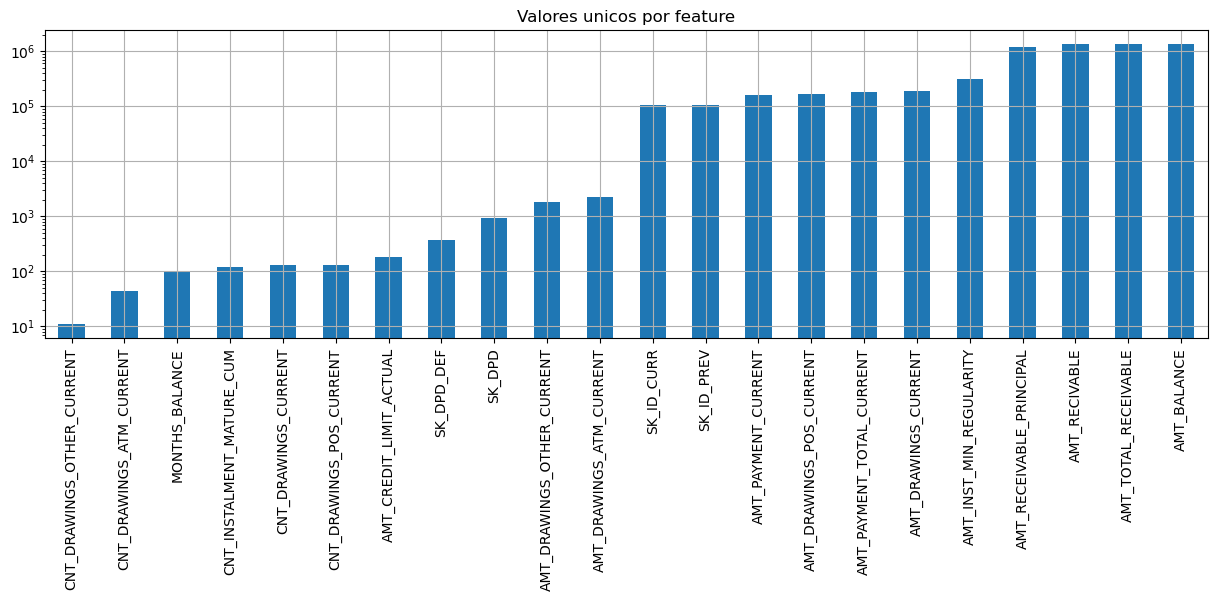

In [8]:
# Por cada feature numerico cuento la cantidad de entradas unicas

unique_values = df.select_dtypes(include="number").nunique().sort_values()

# Ploteo la informacion con el eje-y en escala log para ver los ordenes de magnitud

unique_values.plot.bar(logy=True, figsize=(15, 4), title="Valores unicos por feature")
plt.grid()
plt.show()

## Calidad de datos

### Duplicados

In [9]:
# Veo la cantidad de duplicados que tengo en el index feature

n_duplicates = df.drop(labels=["SK_ID_CURR"], axis=1).duplicated().sum()
print(f"Tenes {n_duplicates} duplicados en tu dataset.")

Tenes 0 duplicados en tu dataset.


No se encontraron filas duplicadas.

### Valores nulos

Text(0, 0.5, 'Sample Number')

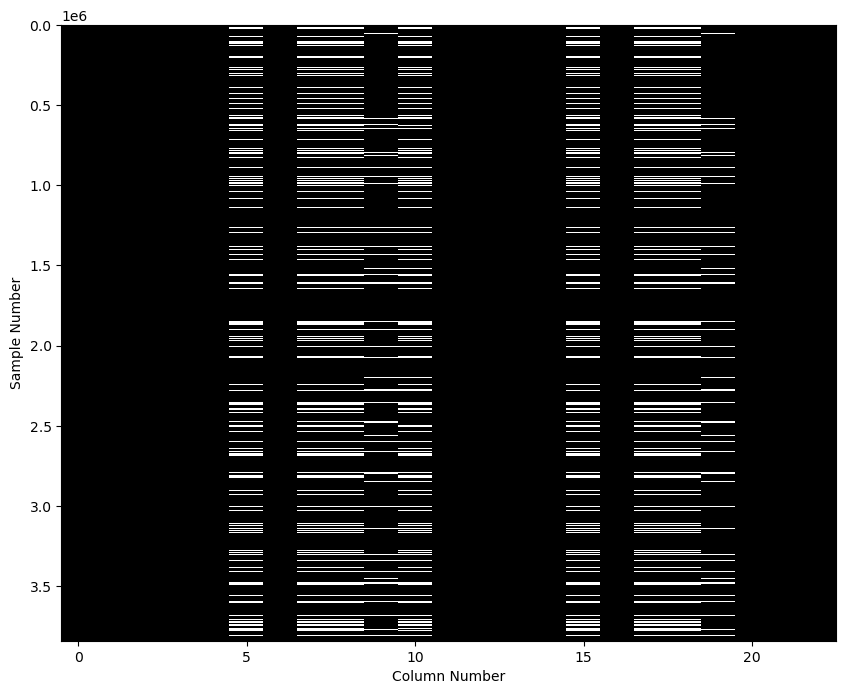

In [10]:
# Aproximacion visual de datos faltantes/nulos

plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")

Se puede ver que tengo un gran faltante de datos en entre las columnas 40 y 90.

In [11]:
# Cantidad y porcentaje de valores nulos en las columnas "categoricas"

print('cantidad de valores nulos en variables categoricas')
cat_nan = pd.concat([pd.DataFrame(df.select_dtypes(exclude='number').isna().sum(), columns=['q_nan']),pd.DataFrame(df.select_dtypes(exclude='number').isna().sum()/len(df.select_dtypes(exclude='number'))*100, columns=['perc_nan'])], axis=1)
print(cat_nan.to_markdown())

cantidad de valores nulos en variables categoricas
|                      |   q_nan |   perc_nan |
|:---------------------|--------:|-----------:|
| NAME_CONTRACT_STATUS |       0 |          0 |


In [12]:
# Cantidad y porcentaje de valores nulos en las columnas numericas

print('cantidad de valores nulos en variables numericas')
num_nan = pd.concat([pd.DataFrame(df.select_dtypes(include='number').isna().sum(), columns=['q_nan']),pd.DataFrame(df.select_dtypes(include='number').isna().sum()/len(df.select_dtypes(include='number'))*100, columns=['perc_nan'])], axis=1)
print(num_nan.to_markdown())

cantidad de valores nulos en variables numericas
|                            |   q_nan |   perc_nan |
|:---------------------------|--------:|-----------:|
| SK_ID_PREV                 |       0 |    0       |
| SK_ID_CURR                 |       0 |    0       |
| MONTHS_BALANCE             |       0 |    0       |
| AMT_BALANCE                |       0 |    0       |
| AMT_CREDIT_LIMIT_ACTUAL    |       0 |    0       |
| AMT_DRAWINGS_ATM_CURRENT   |  749816 |   19.5249  |
| AMT_DRAWINGS_CURRENT       |       0 |    0       |
| AMT_DRAWINGS_OTHER_CURRENT |  749816 |   19.5249  |
| AMT_DRAWINGS_POS_CURRENT   |  749816 |   19.5249  |
| AMT_INST_MIN_REGULARITY    |  305236 |    7.94821 |
| AMT_PAYMENT_CURRENT        |  767988 |   19.9981  |
| AMT_PAYMENT_TOTAL_CURRENT  |       0 |    0       |
| AMT_RECEIVABLE_PRINCIPAL   |       0 |    0       |
| AMT_RECIVABLE              |       0 |    0       |
| AMT_TOTAL_RECEIVABLE       |       0 |    0       |
| CNT_DRAWINGS_ATM_CURRENT   |  7

In [13]:
# Columnas que tienen un porcentaje de datos nulos mayor al 20% (criterio de corte)

num_nan_pos = num_nan[num_nan['perc_nan']>=20]
cat_nan_pos = cat_nan[cat_nan['perc_nan']>=20]

Tomo 20% de tolerancia para los datos faltantes. Si es posible, se deberían pedir los datos para poder rellenar los datos faltantes.

In [14]:
# imprimo en pantalla las columnas con gran porcetanje de datos nulos.

print(num_nan_pos.to_markdown())
print(cat_nan_pos.to_markdown())

| q_nan   | perc_nan   |
|---------|------------|
| q_nan   | perc_nan   |
|---------|------------|


In [15]:
# lista de columnas a dropear por gran cantidad de valores faltantes (mayor al 20%)

col_to_drop = list(num_nan_pos.index)
col_to_drop.extend(list(cat_nan_pos.index))


Dropeo dichas columnas en este momento para que no estorben al momento de graficar las variables.

In [16]:
df.drop(columns=col_to_drop, inplace=True)
df.reset_index(drop=True)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [17]:
#separo los nombres de las columnas en los diferentes tipos de dato

numerical_columns = [x for x in df.columns if df[x].dtype != 'object' and df[x].dtype != 'bool']
cat_columns = [x for x in df.columns if x not in numerical_columns]
int_columns = [x for x in numerical_columns if df[x].dtypes != 'float64']
float_columns = [x for x in numerical_columns if x not in int_columns]

print('cat:',len(cat_columns),'int:', len(int_columns),'float:', len(float_columns))

cat: 1 int: 7 float: 15


### variables categoricas

In [18]:
df[cat_columns].describe().T

,count,unique,top,freq
NAME_CONTRACT_STATUS,3840312,7,Active,3698436


La gran mayoría posee poca cantidad de valores unicos distintos, por lo que se estima un onehotenconding. 
El featrue ORGANIZATION_TYPE posee 58 valores distintos, se debería ver la distribución de dichos valores.

<AxesSubplot: >

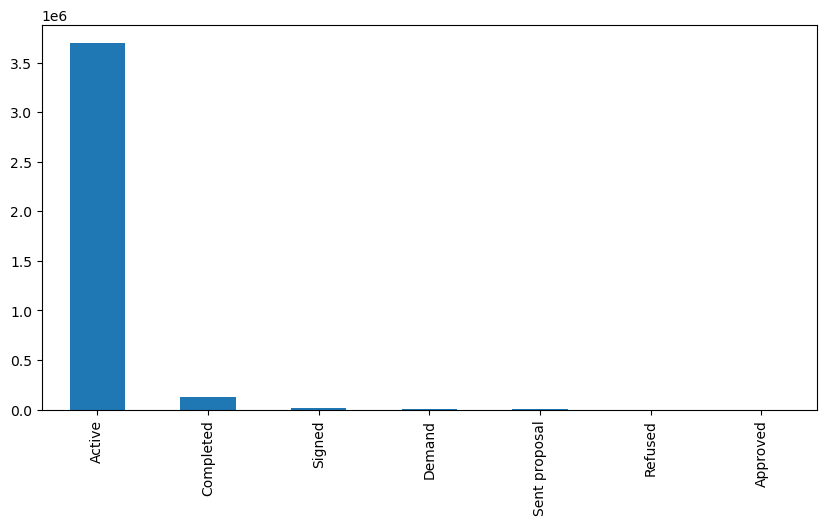

In [20]:
df['NAME_CONTRACT_STATUS'].value_counts().plot(kind='bar', figsize=(10,5))

### Variables numericas

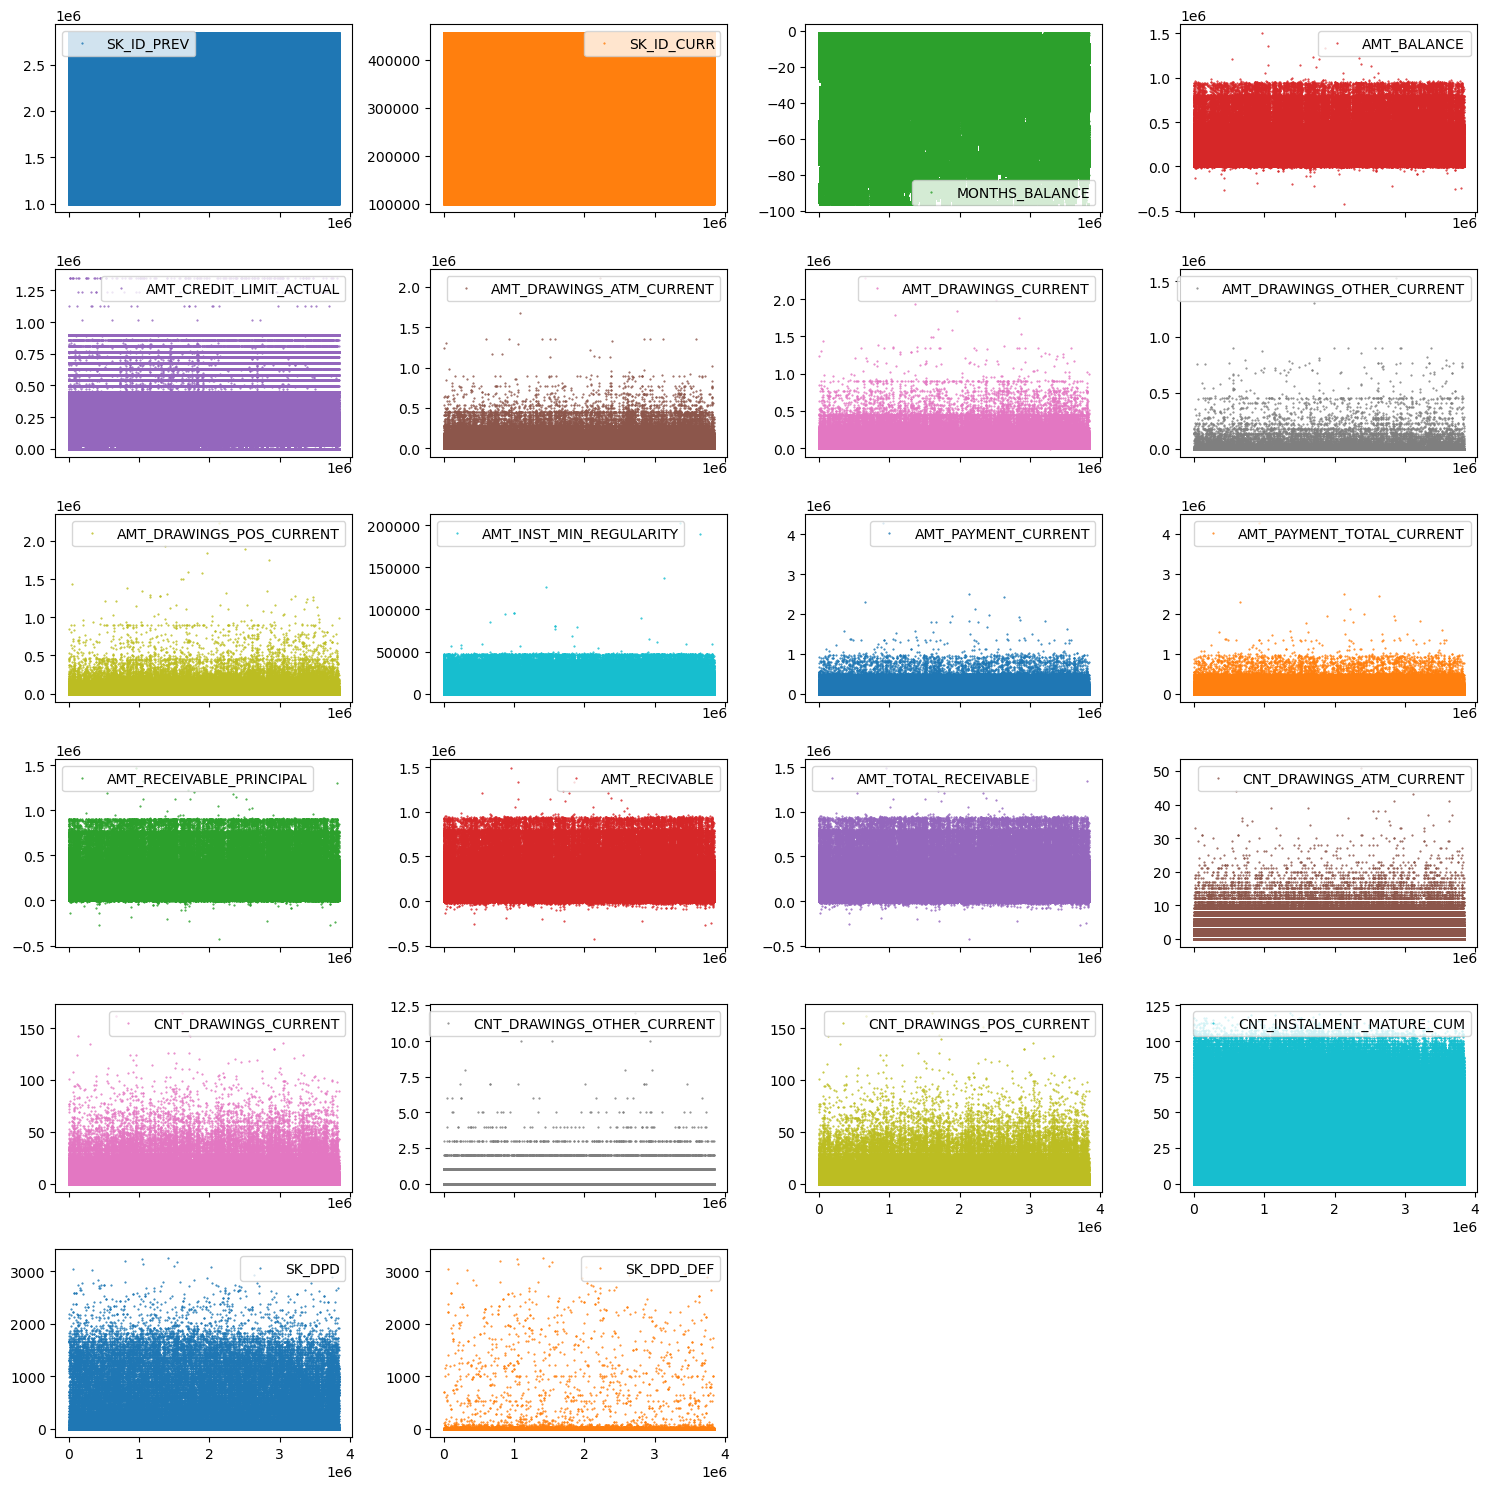

In [21]:
# Me fijo como son los datos en el dataset. esto me ayuda a detectar los datos faltantes.  


df.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),figsize=(15, 15), markersize=1)
plt.tight_layout()

#### variables enteras/discretas

In [22]:
df[int_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,3840312.0,1.904504e+06,536469.470563,1000018.0,1434385.0,1897122.0,2369327.75,2843496.0
SK_ID_CURR,3840312.0,2.783242e+05,102704.475133,100006.0,189517.0,278396.0,367580.00,456250.0
MONTHS_BALANCE,3840312.0,-3.452192e+01,26.667751,-96.0,-55.0,-28.0,-11.00,-1.0
AMT_CREDIT_LIMIT_ACTUAL,3840312.0,1.538080e+05,165145.699525,0.0,45000.0,112500.0,180000.00,1350000.0
CNT_DRAWINGS_CURRENT,3840312.0,7.031439e-01,3.190347,0.0,0.0,0.0,0.00,165.0
SK_DPD,3840312.0,9.283667e+00,97.515700,0.0,0.0,0.0,0.00,3260.0
SK_DPD_DEF,3840312.0,3.316220e-01,21.479231,0.0,0.0,0.0,0.00,3260.0


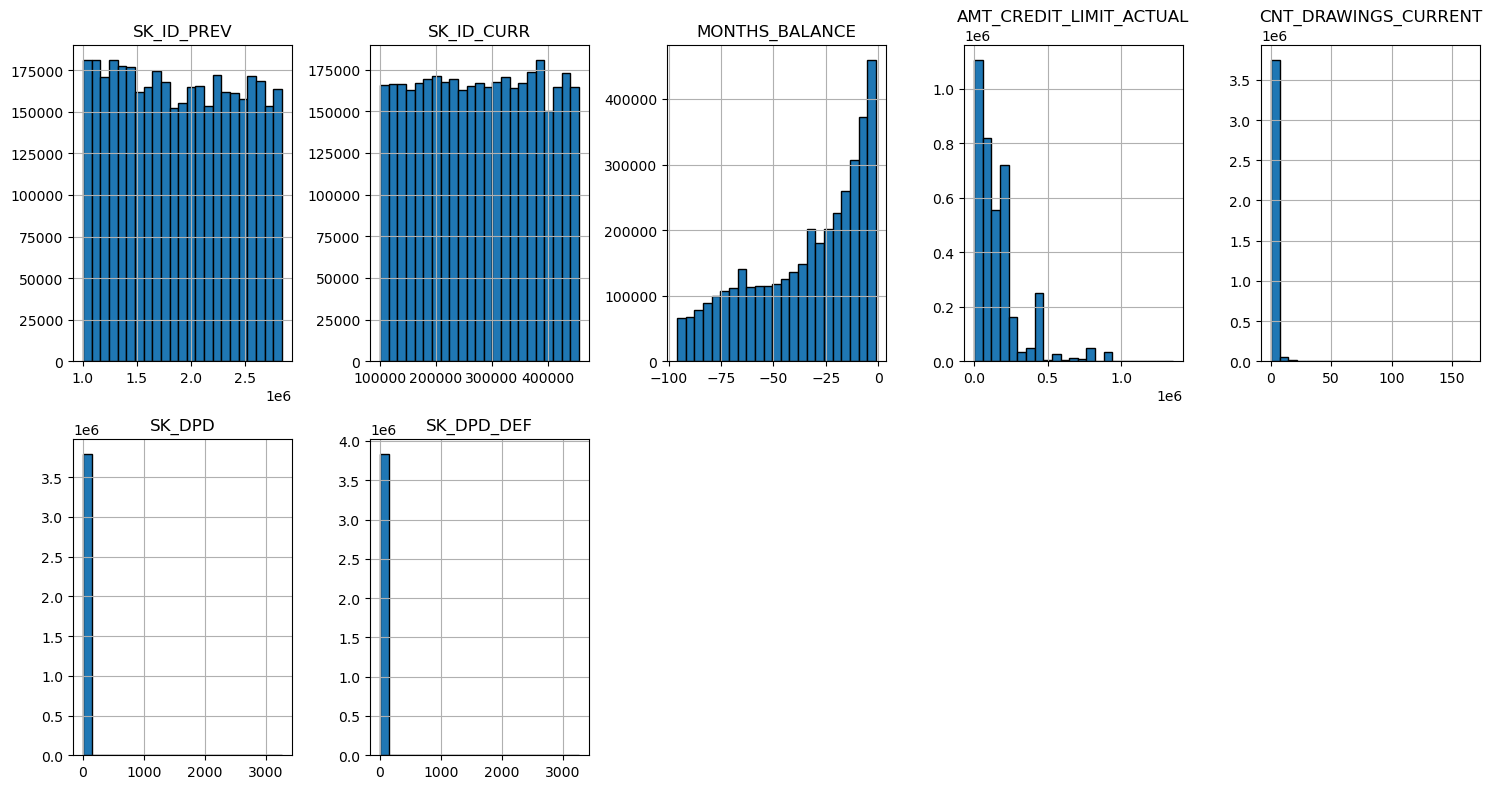

In [26]:
# cantidad de bins que debería tener mi histograma. Utilizo el criterio de Sturge.

n_bins = round(1 + 3.322 * np.log10(len(df)))

# Ploteo histogramas de las variables dtype=int64

df[[x for x in int_columns if x != 'TARGET']].hist(bins=n_bins, figsize=(15, 8), layout=(-1, 5), edgecolor="black")
plt.tight_layout()

#### variables continuas

In [27]:
df[float_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_BALANCE,3840312.0,58300.155262,106307.031024,-420250.185,0.00,0.0,89046.68625,1505902.185
AMT_DRAWINGS_ATM_CURRENT,3090496.0,5961.324822,28225.688578,-6827.310,0.00,0.0,0.00000,2115000.000
AMT_DRAWINGS_CURRENT,3840312.0,7433.388179,33846.077333,-6211.620,0.00,0.0,0.00000,2287098.315
AMT_DRAWINGS_OTHER_CURRENT,3090496.0,288.169582,8201.989345,0.000,0.00,0.0,0.00000,1529847.000
AMT_DRAWINGS_POS_CURRENT,3090496.0,2968.804848,20796.887047,0.000,0.00,0.0,0.00000,2239274.160
AMT_INST_MIN_REGULARITY,3535076.0,3540.204129,5600.154122,0.000,0.00,0.0,6633.91125,202882.005
AMT_PAYMENT_CURRENT,3072324.0,10280.537702,36078.084953,0.000,152.37,2702.7,9000.00000,4289207.445
AMT_PAYMENT_TOTAL_CURRENT,3840312.0,7588.856739,32005.987768,0.000,0.00,0.0,6750.00000,4278315.690
AMT_RECEIVABLE_PRINCIPAL,3840312.0,55965.876905,102533.616846,-423305.820,0.00,0.0,85359.24000,1472316.795
AMT_RECIVABLE,3840312.0,58088.811177,105965.369908,-420250.185,0.00,0.0,88899.49125,1493338.185


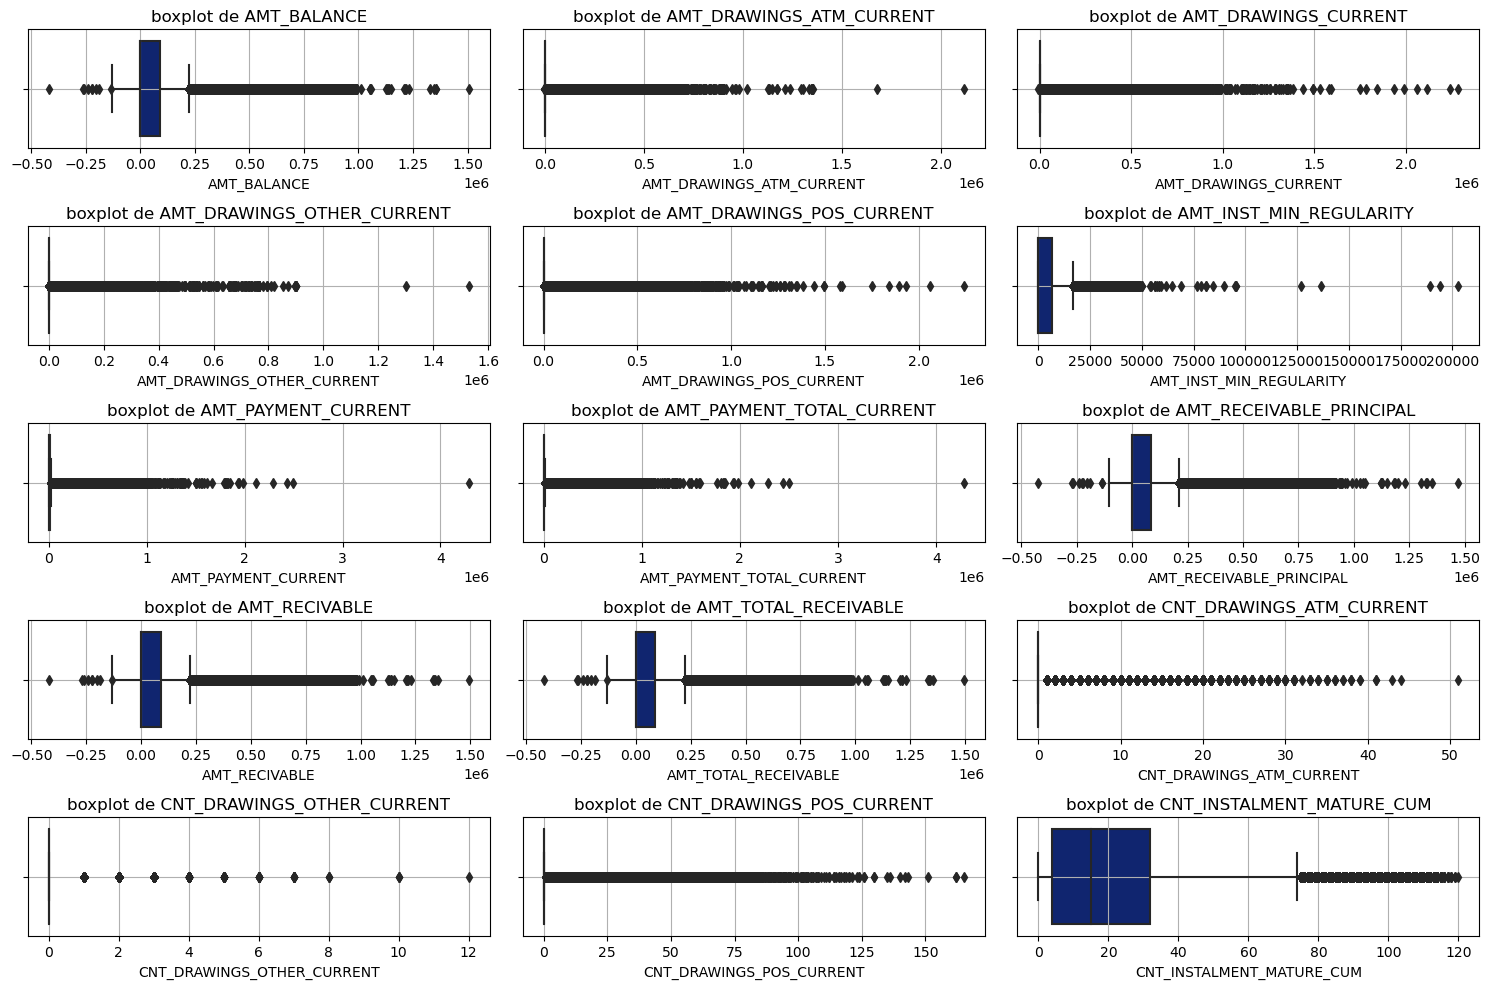

In [29]:
# veo las distribuciones de las varaibles con dtype=float64

plt.figure(figsize=(15,10))
for index, column in enumerate([x for x in float_columns]):
  plt.subplot(ceil(len(float_columns)/3), 3, index+1)
  sns.boxplot(data=df, x=df[column], palette='dark')
  plt.title('boxplot de {}'.format(column))
  plt.grid()  
  plt.tight_layout()

/Users/santiagogimenez/miniconda3/envs/nx-challenge/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/santiagogimenez/miniconda3/envs/nx-challenge/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/santiagogimenez/miniconda3/envs/nx-challenge/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/santiagogimenez/miniconda3/envs/nx-challenge/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/santiagogimenez/miniconda3/envs/nx-challenge/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value enco

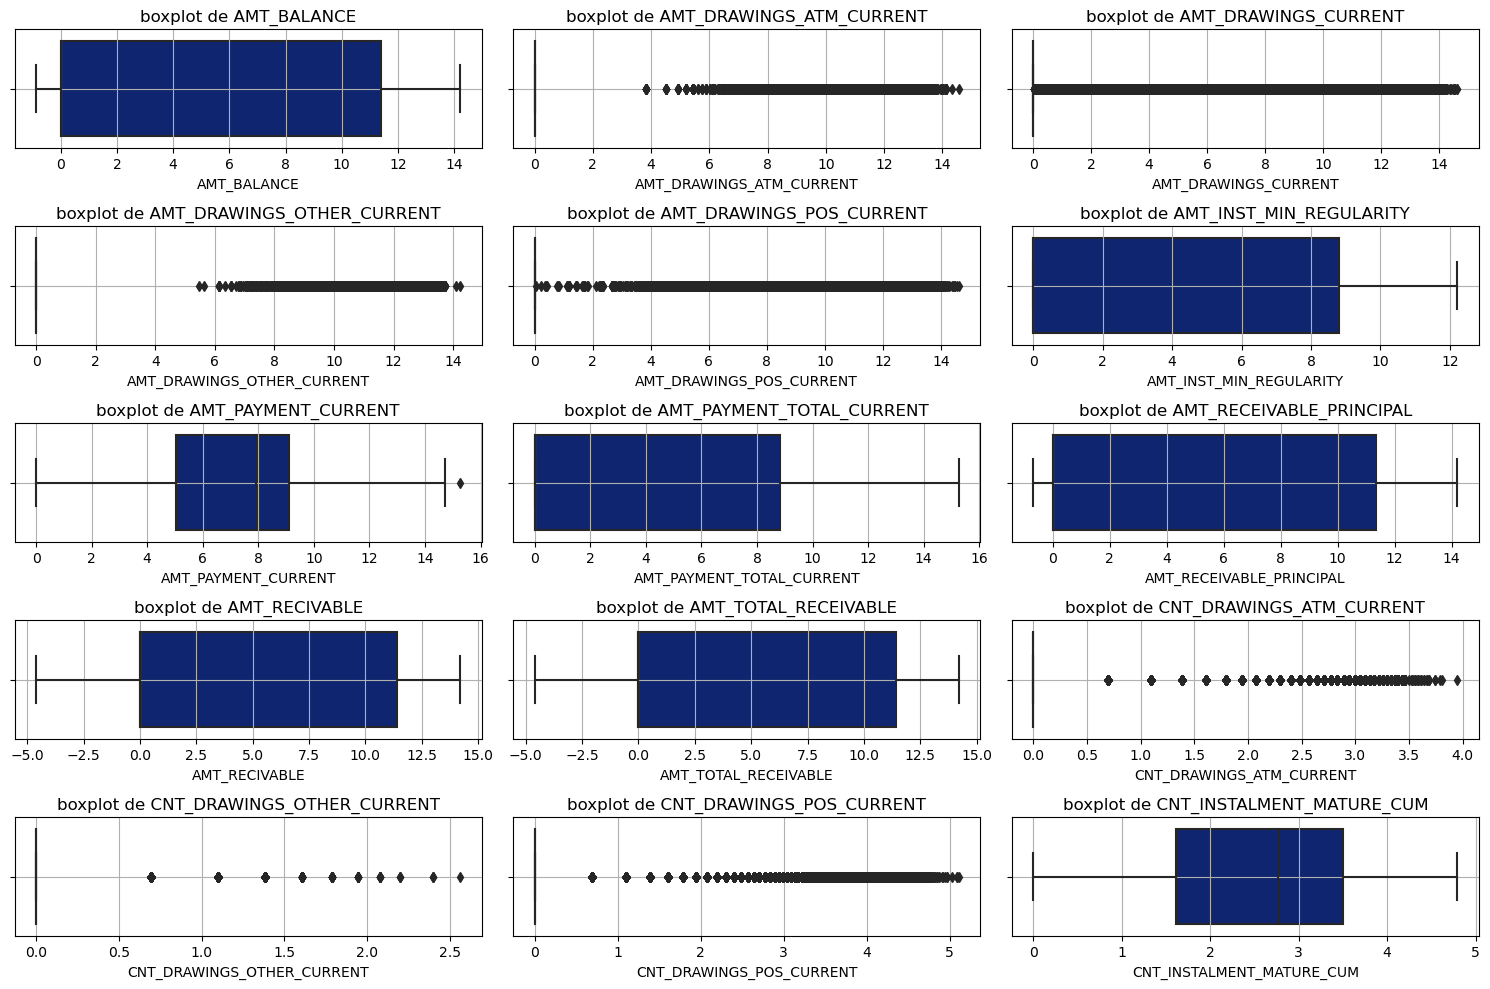

In [50]:
plt.figure(figsize=(15,10))
for index, column in enumerate([x for x in float_columns]):
  plt.subplot(ceil(len(float_columns)/3), 3, index+1)
  sns.boxplot(data=df, x=np.log1p(df[column]), palette='dark')
  plt.title('boxplot de {}'.format(column))
  plt.grid()  
  plt.tight_layout()

In [30]:
# me armo el percentil 99% para las diferentes variables que parecen tener outliers.

outliers_detection = float_columns
outlier_treshold = pd.DataFrame(df.describe(percentiles=[0.99]).loc['99%']).T
outlier_treshold[outliers_detection]

,AMT_BALANCE,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM
99%,466295.11605,135000.0,157500.0,0.0,77080.608,23312.80125,150617.43,128614.9293,448121.8251,464023.8567,464025.50685,5.0,0.0,14.0,80.0


In [31]:
# me fijo la cantidad de valores que pasan el treshold del percentil 99.5%. Estos son los cantidatos a ser eliminados.

for outlier in outliers_detection:
    print(outlier,
    ':',
    pd.DataFrame(df[abs(df[outlier]) > abs(outlier_treshold[outlier].loc['99%'])][outlier]).shape[0], 
    '(',
    pd.DataFrame(df[abs(df[outlier]) > abs(outlier_treshold[outlier].loc['99%'])][outlier]).shape[0]/len(df[outlier])*100 ,
    '%)')


AMT_BALANCE : 38404 ( 1.0000229148048387 %)
AMT_DRAWINGS_ATM_CURRENT : 27077 ( 0.7050729211584892 %)
AMT_DRAWINGS_CURRENT : 37575 ( 0.978436127064676 %)
AMT_DRAWINGS_OTHER_CURRENT : 12333 ( 0.3211457819052202 %)
AMT_DRAWINGS_POS_CURRENT : 30905 ( 0.8047523222071541 %)
AMT_INST_MIN_REGULARITY : 35351 ( 0.9205241657448666 %)
AMT_PAYMENT_CURRENT : 30723 ( 0.8000131239336804 %)
AMT_PAYMENT_TOTAL_CURRENT : 38404 ( 1.0000229148048387 %)
AMT_RECEIVABLE_PRINCIPAL : 38404 ( 1.0000229148048387 %)
AMT_RECIVABLE : 38404 ( 1.0000229148048387 %)
AMT_TOTAL_RECEIVABLE : 38404 ( 1.0000229148048387 %)
CNT_DRAWINGS_ATM_CURRENT : 27696 ( 0.7211914031984902 %)
CNT_DRAWINGS_OTHER_CURRENT : 12808 ( 0.33351456860796724 %)
CNT_DRAWINGS_POS_CURRENT : 30822 ( 0.8025910394780424 %)
CNT_INSTALMENT_MATURE_CUM : 32814 ( 0.8544618249767207 %)


In [34]:
# me fijo la relación entre las familias con mas de diez integrantes y la cantidad de hijos e hijas que tienen.

df[(df['AMT_PAYMENT_TOTAL_CURRENT']>=3*10**6)][['AMT_PAYMENT_TOTAL_CURRENT']]

,AMT_PAYMENT_TOTAL_CURRENT
918470,4278315.69


In [51]:
df[(df['AMT_PAYMENT_CURRENT']>=3*10**6)][['AMT_PAYMENT_CURRENT']]

,AMT_PAYMENT_CURRENT
918470,4289207.445


In [40]:
# me fijo la relación entre las variables de cantidad de personas en default en el entorno del cliente. (Después se observa que hay gran correlacion entre OBS_60 y OBS_30)

df[df['AMT_DRAWINGS_ATM_CURRENT']>= 2*10**6 ]['AMT_DRAWINGS_ATM_CURRENT']

2215371    2115000.0
Name: AMT_DRAWINGS_ATM_CURRENT, dtype: float64

Este parece ser un outlier. Porque es el único valor tan alto que existe.

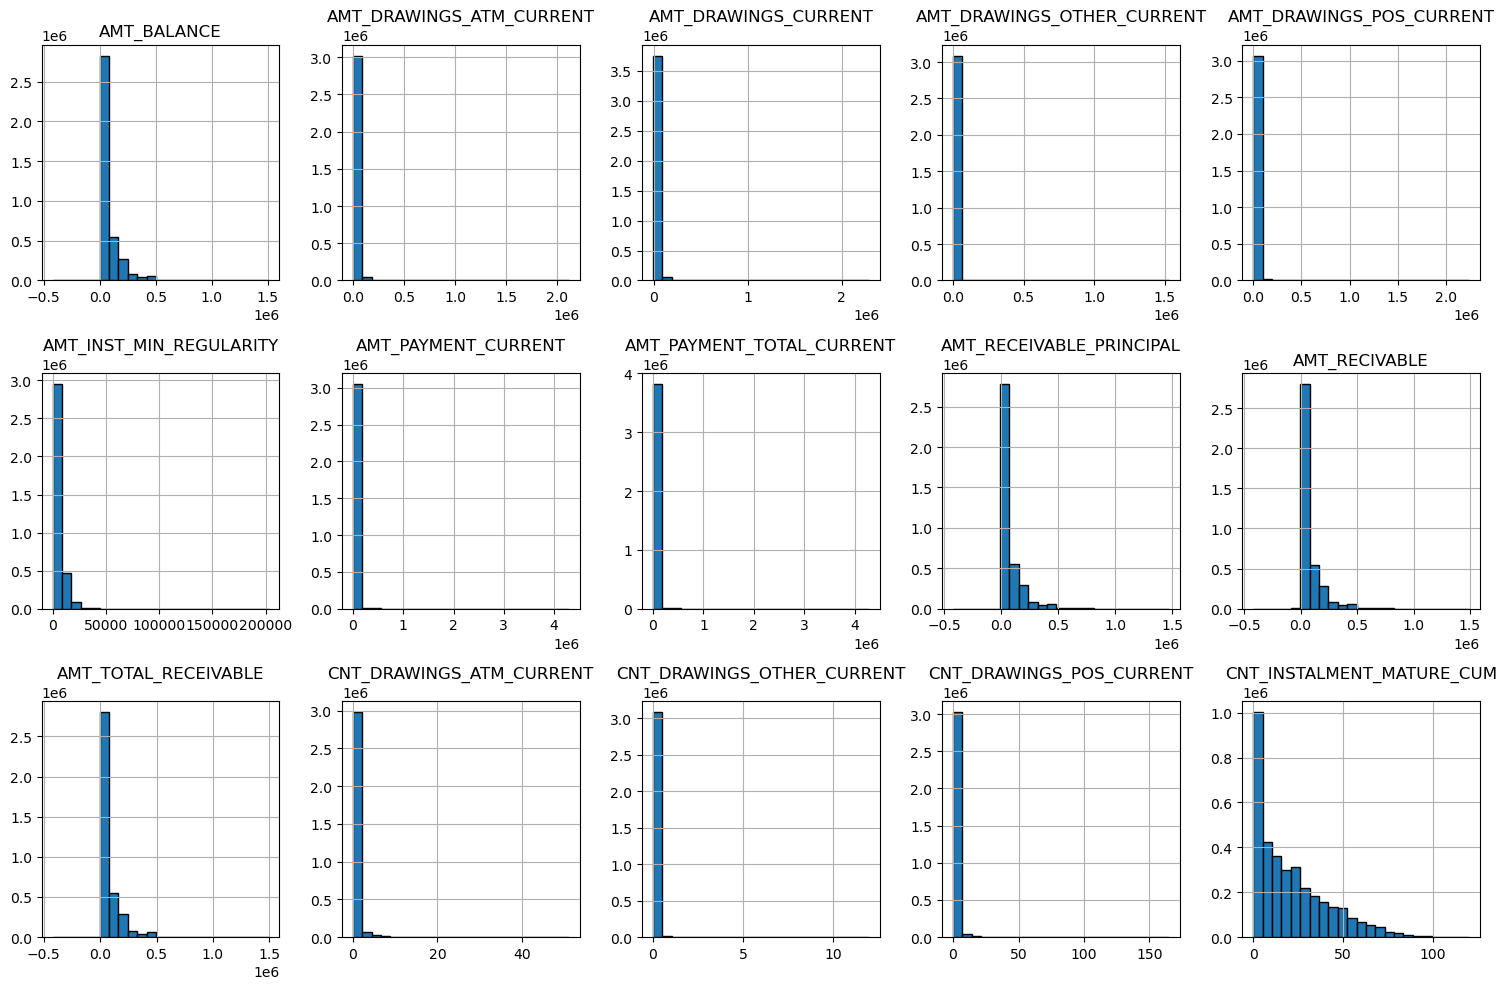

In [47]:
# ploteos de las variables con dtype=float64
n_bins = round(1 + 3.322 * np.log10(len(df)))

df[float_columns].hist(bins=n_bins, figsize=(15, 10), layout=(-1, 5), edgecolor="black")
plt.tight_layout()

### tabla de correlaciones

/var/folders/8z/vjxlhv2s499b46l6s62czlmm0000gn/T/ipykernel_29337/1586622766.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

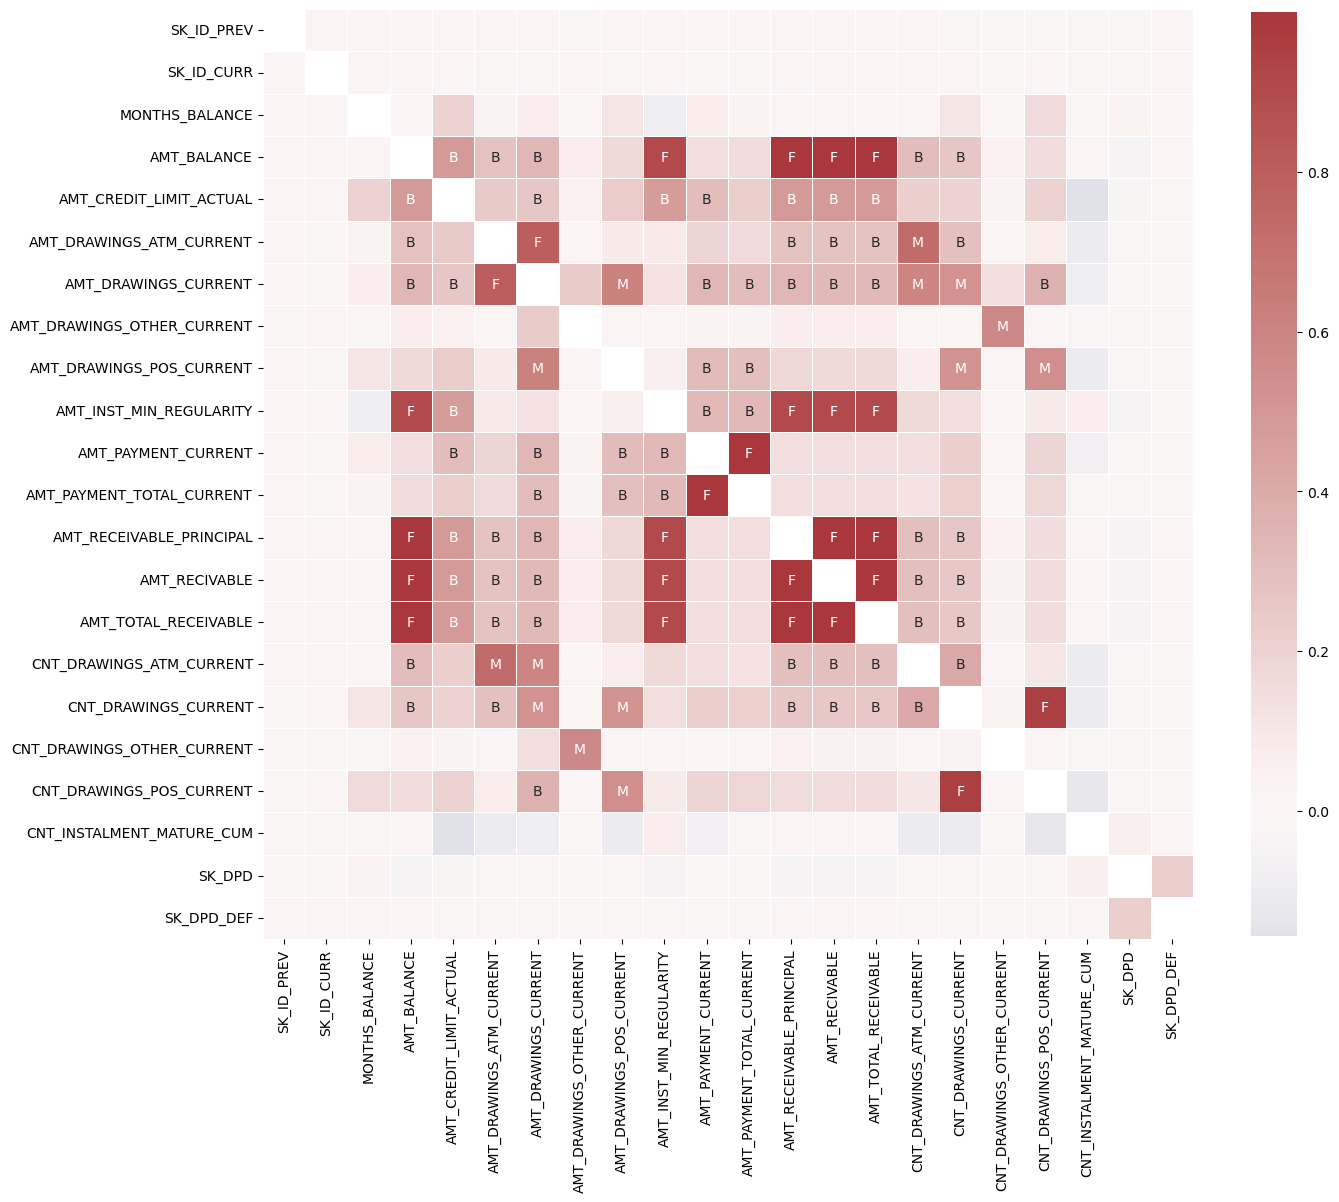

In [43]:
# calculo las correlaciones entre las variables numericas
corr = df.corr()

# creo labels para las correlaciones
labels = np.where(np.abs(corr)>0.75, "F",
                  np.where(np.abs(corr)>0.5, "M",
                  np.where(np.abs(corr)>0.25, "B", "")))

# ploteo correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr, mask=np.eye(len(corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8})

In [44]:
#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(corr.shape), k=-1).astype("bool")

#  Stack all correlations, after applying the mask
corr_stacked = corr.where(lower_triangle_mask).stack().sort_values()

#  Showing the lowest and highest correlations in the correlation matrix
display(corr_stacked)

CNT_INSTALMENT_MATURE_CUM  AMT_CREDIT_LIMIT_ACTUAL    -0.157269
                           CNT_DRAWINGS_POS_CURRENT   -0.129338
                           AMT_DRAWINGS_POS_CURRENT   -0.106813
                           AMT_DRAWINGS_ATM_CURRENT   -0.103721
                           CNT_DRAWINGS_ATM_CURRENT   -0.103403
                                                         ...   
AMT_RECEIVABLE_PRINCIPAL   AMT_BALANCE                 0.999720
AMT_RECIVABLE              AMT_RECEIVABLE_PRINCIPAL    0.999727
AMT_TOTAL_RECEIVABLE       AMT_BALANCE                 0.999897
AMT_RECIVABLE              AMT_BALANCE                 0.999917
AMT_TOTAL_RECEIVABLE       AMT_RECIVABLE               0.999995
Length: 231, dtype: float64

In [45]:
corr_stacked.head(15)

CNT_INSTALMENT_MATURE_CUM  AMT_CREDIT_LIMIT_ACTUAL    -0.157269
                           CNT_DRAWINGS_POS_CURRENT   -0.129338
                           AMT_DRAWINGS_POS_CURRENT   -0.106813
                           AMT_DRAWINGS_ATM_CURRENT   -0.103721
                           CNT_DRAWINGS_ATM_CURRENT   -0.103403
                           CNT_DRAWINGS_CURRENT       -0.099186
                           AMT_DRAWINGS_CURRENT       -0.093491
AMT_INST_MIN_REGULARITY    MONTHS_BALANCE             -0.087529
CNT_INSTALMENT_MATURE_CUM  AMT_PAYMENT_CURRENT        -0.079266
SK_DPD                     AMT_INST_MIN_REGULARITY    -0.061484
                           AMT_RECEIVABLE_PRINCIPAL   -0.048290
                           AMT_BALANCE                -0.046988
                           AMT_RECIVABLE              -0.046434
                           AMT_TOTAL_RECEIVABLE       -0.046047
                           AMT_CREDIT_LIMIT_ACTUAL    -0.038791
dtype: float64

In [46]:
corr_stacked.tail(15)

AMT_DRAWINGS_POS_CURRENT   AMT_DRAWINGS_CURRENT        0.615591
CNT_DRAWINGS_ATM_CURRENT   AMT_DRAWINGS_ATM_CURRENT    0.732907
AMT_DRAWINGS_CURRENT       AMT_DRAWINGS_ATM_CURRENT    0.800190
AMT_RECEIVABLE_PRINCIPAL   AMT_INST_MIN_REGULARITY     0.896030
AMT_INST_MIN_REGULARITY    AMT_BALANCE                 0.896728
AMT_TOTAL_RECEIVABLE       AMT_INST_MIN_REGULARITY     0.897587
AMT_RECIVABLE              AMT_INST_MIN_REGULARITY     0.897617
CNT_DRAWINGS_POS_CURRENT   CNT_DRAWINGS_CURRENT        0.950546
AMT_PAYMENT_TOTAL_CURRENT  AMT_PAYMENT_CURRENT         0.994764
AMT_TOTAL_RECEIVABLE       AMT_RECEIVABLE_PRINCIPAL    0.999702
AMT_RECEIVABLE_PRINCIPAL   AMT_BALANCE                 0.999720
AMT_RECIVABLE              AMT_RECEIVABLE_PRINCIPAL    0.999727
AMT_TOTAL_RECEIVABLE       AMT_BALANCE                 0.999897
AMT_RECIVABLE              AMT_BALANCE                 0.999917
AMT_TOTAL_RECEIVABLE       AMT_RECIVABLE               0.999995
dtype: float64

Estos features tienen una correlacion alta. Se tiene que tener en cuenta que pueden llegar a añadir colinealidad al modelo.

## Conclusiones

- Crear nuevos features que agrupen columnas (CNT_TOTAL_DRAWINGS, AMT_TOTAL_DRAWINGS)

- Es necesario agrupar la información por medio de la pk SK_ID_CURR para poder utilizarla junto con las otras dos tablas.

- Se necesita realizar algún tipo de función agregada para poder agruparse.

- Se necesita rellenar los datos faltantes con algún método en concreto. Media, moda, etc.

- La columna categórica la descartaré en este aproach.

- Existen casos de outliers. Solamente se borrarán aquellos casos completamente extremos.

- Se Necesita eliminar variables que tengan mucha correlación entre sí por la posibilidad de agregar colinealidad. Hay muchas que tiene una gran correlación entre sí.


# Pre - preparación de datos

In [59]:
df

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,CNT_TOTAL_DRAWINGS,AMT_TOTAL_DRAWINGS
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.0,1,0.0,1.0,35.0,Active,0,0,2.0,1755.0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,1.0,1,0.0,0.0,69.0,Active,0,0,2.0,4500.0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,0.0,0,0.0,0.0,30.0,Active,0,0,0.0,0.0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,1.0,1,0.0,0.0,10.0,Active,0,0,2.0,4500.0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,0.0,1,0.0,1.0,101.0,Active,0,0,2.0,23094.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,NaN,0,NaN,NaN,0.0,Active,0,0,NaN,NaN
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.0,0,0.0,0.0,23.0,Active,0,0,0.0,0.0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,2.0,2,0.0,0.0,18.0,Active,0,0,4.0,540000.0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,NaN,0,NaN,NaN,0.0,Active,0,0,NaN,NaN


In [56]:
# me genero nuevos features para 

df['CNT_TOTAL_DRAWINGS'] = df['CNT_DRAWINGS_ATM_CURRENT'] + df['CNT_DRAWINGS_CURRENT'] + df['CNT_DRAWINGS_OTHER_CURRENT'] + df['CNT_DRAWINGS_POS_CURRENT']
df['AMT_TOTAL_DRAWINGS'] = df['AMT_DRAWINGS_ATM_CURRENT'] + df['AMT_DRAWINGS_CURRENT'] + df['AMT_DRAWINGS_OTHER_CURRENT'] + df['AMT_DRAWINGS_POS_CURRENT']

In [62]:
# me defino un dataset con los nuevos features y me quedo con las columnas que me interesa. elimino aquellas que no son una suma TOTAL de montos o cantidades. También elimino las variables que no puedo agrupar, como la categorica y la
# que se trata de SK_ID_PREV.

df_new_features = df[['SK_ID_CURR','MONTHS_BALANCE','AMT_BALANCE','AMT_CREDIT_LIMIT_ACTUAL','AMT_TOTAL_DRAWINGS','AMT_INST_MIN_REGULARITY',
                    'AMT_PAYMENT_TOTAL_CURRENT','AMT_TOTAL_RECEIVABLE','CNT_TOTAL_DRAWINGS','CNT_INSTALMENT_MATURE_CUM', 
                    'SK_DPD', 'SK_DPD_DEF']]

df_new_features

,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_TOTAL_DRAWINGS,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_TOTAL_DRAWINGS,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
0,378907,-6,56.970,135000,1755.0,1700.325,1800.000,0.000,2.0,35.0,0,0
1,363914,-1,63975.555,45000,4500.0,2250.000,2250.000,64875.555,2.0,69.0,0,0
2,371185,-7,31815.225,450000,0.0,2250.000,2250.000,31460.085,0.0,30.0,0,0
3,337855,-4,236572.110,225000,4500.0,11795.760,11925.000,233048.970,2.0,10.0,0,0
4,126868,-1,453919.455,450000,23094.0,22924.890,27000.000,453919.455,2.0,101.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,328243,-9,0.000,45000,NaN,0.000,0.000,0.000,NaN,0.0,0,0
3840308,347207,-9,0.000,45000,0.0,0.000,0.000,0.000,0.0,23.0,0,0
3840309,215757,-9,275784.975,585000,540000.0,2250.000,356994.675,273093.975,4.0,18.0,0,0
3840310,430337,-10,0.000,450000,NaN,0.000,0.000,0.000,NaN,0.0,0,0


In [63]:
# Agrupo los valores en funcion de la pk SK_ID_CURR para poder unirla con las otras tablas.

df_grouped = df_new_features.groupby(by=['SK_ID_CURR']).mean()
df_grouped

,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_TOTAL_DRAWINGS,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_TOTAL_DRAWINGS,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
SK_ID_CURR,,,,,,,,,,,
100006,-3.5,0.000000,270000.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
100011,-38.5,54482.111149,164189.189189,4864.864865,3956.221849,4520.067568,54433.179122,0.108108,25.767123,0.000000,0.000000
100013,-48.5,18159.919219,131718.750000,12700.000000,1454.539551,6817.172344,18101.079844,0.511111,18.719101,0.010417,0.010417
100021,-10.0,0.000000,675000.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
100023,-7.5,0.000000,135000.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
456244,-21.0,131834.730732,296341.463415,53681.013659,6514.200000,32720.544878,130767.060732,2.731707,13.600000,0.000000,0.000000
456246,-5.5,13136.731875,135000.000000,30398.512500,1439.150625,15554.340000,12897.894375,5.000000,3.500000,0.000000,0.000000
456247,-49.0,23216.396211,144000.000000,4299.012947,1414.704789,4115.878105,23128.243105,0.294737,26.494737,0.031579,0.021053


<AxesSubplot: >

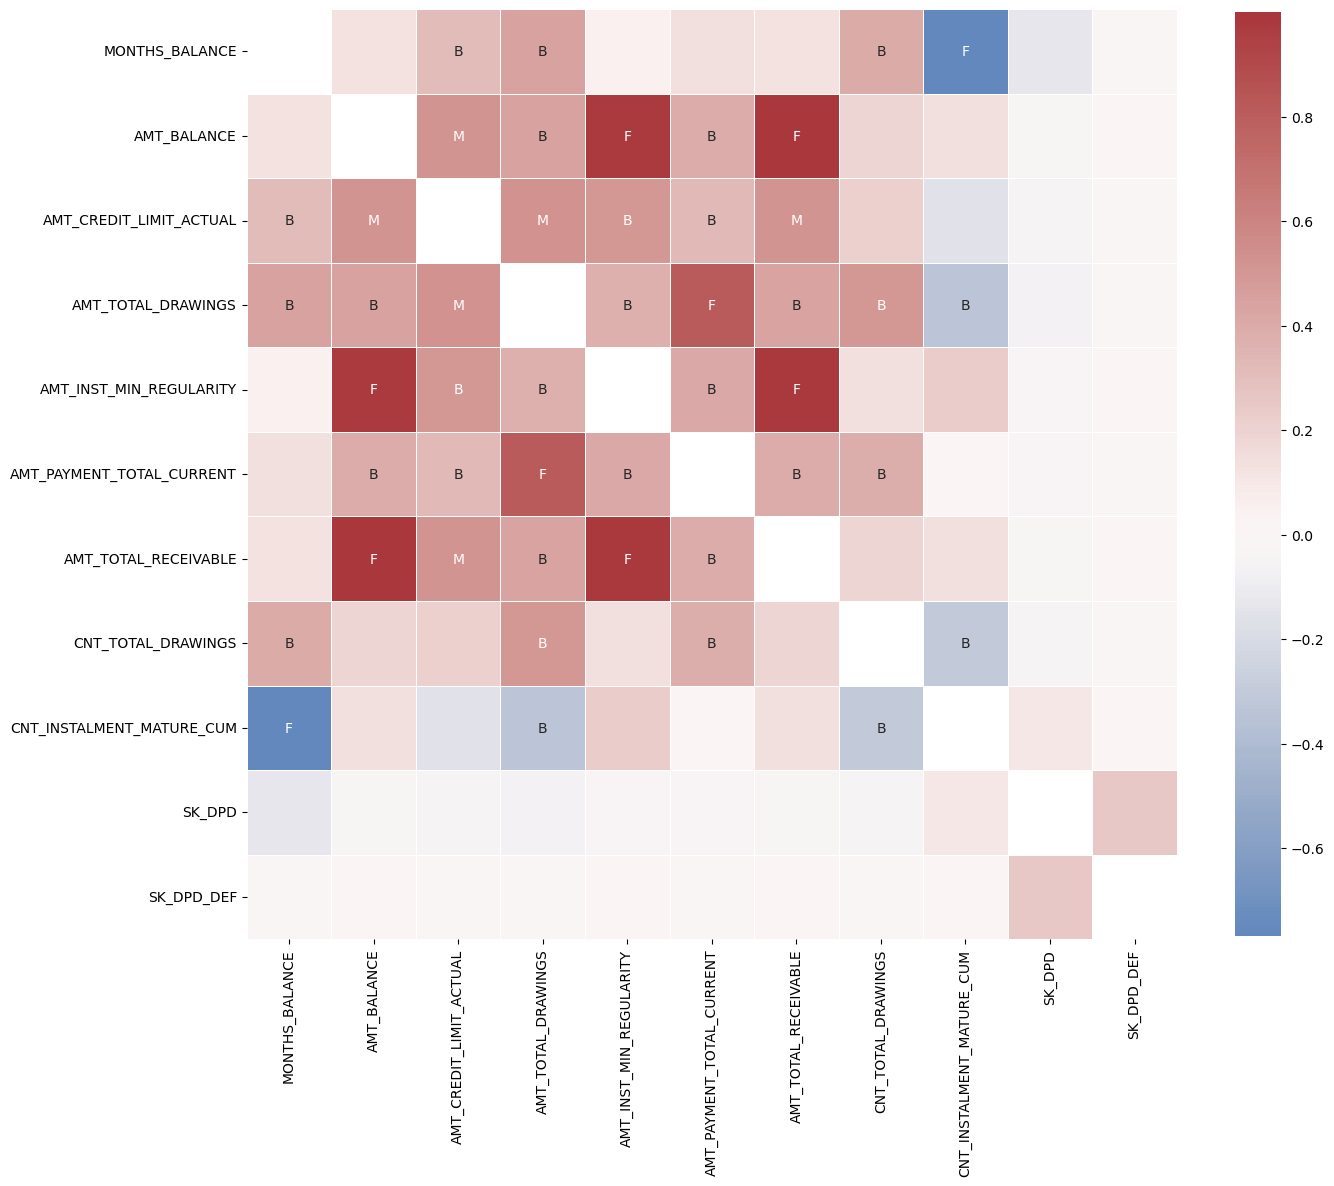

In [64]:
corr_grouped = df_grouped.corr()

# creo labels para las correlaciones
labels = np.where(np.abs(corr_grouped)>0.75, "F",
                  np.where(np.abs(corr_grouped)>0.5, "M",
                  np.where(np.abs(corr_grouped)>0.25, "B", "")))

# ploteo correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr_grouped, mask=np.eye(len(corr_grouped)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8})

In [65]:
#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(corr_grouped.shape), k=-1).astype("bool")

#  Stack all correlations, after applying the mask
corr_stacked = corr_grouped.where(lower_triangle_mask).stack().sort_values()

#  Showing the lowest and highest correlations in the correlation matrix
display(corr_stacked)

CNT_INSTALMENT_MATURE_CUM  MONTHS_BALANCE              -0.768571
                           AMT_TOTAL_DRAWINGS          -0.339006
                           CNT_TOTAL_DRAWINGS          -0.306315
                           AMT_CREDIT_LIMIT_ACTUAL     -0.159194
SK_DPD                     MONTHS_BALANCE              -0.133263
                           AMT_TOTAL_DRAWINGS          -0.065046
                           CNT_TOTAL_DRAWINGS          -0.054789
                           AMT_CREDIT_LIMIT_ACTUAL     -0.050002
                           AMT_BALANCE                 -0.037881
                           AMT_TOTAL_RECEIVABLE        -0.037039
                           AMT_INST_MIN_REGULARITY     -0.032761
                           AMT_PAYMENT_TOTAL_CURRENT   -0.030131
SK_DPD_DEF                 MONTHS_BALANCE              -0.017819
                           AMT_TOTAL_DRAWINGS          -0.008745
                           CNT_TOTAL_DRAWINGS          -0.007376
                         

In [67]:
# me quedo solamente con balance porque los otros me siguen dando correlaciones altas

df_final = df_grouped.drop(columns=['AMT_TOTAL_RECEIVABLE', 'AMT_INST_MIN_REGULARITY'])
df_final

,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_TOTAL_DRAWINGS,AMT_PAYMENT_TOTAL_CURRENT,CNT_TOTAL_DRAWINGS,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
SK_ID_CURR,,,,,,,,,
100006,-3.5,0.000000,270000.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000
100011,-38.5,54482.111149,164189.189189,4864.864865,4520.067568,0.108108,25.767123,0.000000,0.000000
100013,-48.5,18159.919219,131718.750000,12700.000000,6817.172344,0.511111,18.719101,0.010417,0.010417
100021,-10.0,0.000000,675000.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000
100023,-7.5,0.000000,135000.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
456244,-21.0,131834.730732,296341.463415,53681.013659,32720.544878,2.731707,13.600000,0.000000,0.000000
456246,-5.5,13136.731875,135000.000000,30398.512500,15554.340000,5.000000,3.500000,0.000000,0.000000
456247,-49.0,23216.396211,144000.000000,4299.012947,4115.878105,0.294737,26.494737,0.031579,0.021053


In [69]:
df_final.to_csv('preprocessed_credit.csv')